In [31]:
# Import necessary libraries
import os
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import boxcox
import warnings

# Scikit-learn imports
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    KFold,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

In [32]:
warnings.simplefilter(action='ignore')
sns.set_theme()
plt.style.use("ggplot")

# For reproducibility
RANDOM_STATE = 42

### ---------------------------
### 1. Data Loading & EDA
### ---------------------------

In [33]:
df = pd.read_csv("diabetes.csv")

#### Context
<p>Ce jeu de données provient à l'origine de l'Institut national du diabète et des maladies digestives et rénales. L'objectif est de prédire, à partir de mesures diagnostiques, si un patient est diabétique.</p>

#### Content
<p>Plusieurs contraintes ont été imposées pour la sélection de ces instances à partir d'une base de données plus large. En particulier, toutes les patientes ici sont des femmes d'au moins 21 ans d'origine indienne Pima.</p>


<ul>
  <li>Pregnancies: Nombre de fois enceinte</li>
  <li>Glucose: Concentration de glucose plasmatique 2 heures après un test de tolérance au glucose par voie orale</li>
  <li>BloodPressure: Pression artérielle diastolique (mm Hg)</li>
  <li>SkinThickness: Épaisseur du pli cutané tricipital (mm)</li>
  <li>Insulin: Insuline sérique 2 heures (mu U/ml)</li>
  <li>BMI: Indice de masse corporelle (poids en kg/(taille en m)^2)</li>
  <li>DiabetesPedigreeFunction: Fonction pédigrée du diabète</li>
  <li>Age: Age (années)</li>
  <li>Outcome: Variable de classe (0 ou 1)</li>
</ul>

In [34]:
# Preview the data
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [35]:
# Display information about data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [36]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [37]:
# descriptive statistics of the dataset
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [38]:
# Check the shape of the dataset (rows, columns)
df.shape

(768, 9)

In [39]:
# Check the distribution of the outcome variable
print("Outcome distribution (%):")
print((df["Outcome"].value_counts(normalize=True) * 100))

Outcome distribution (%):
Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64


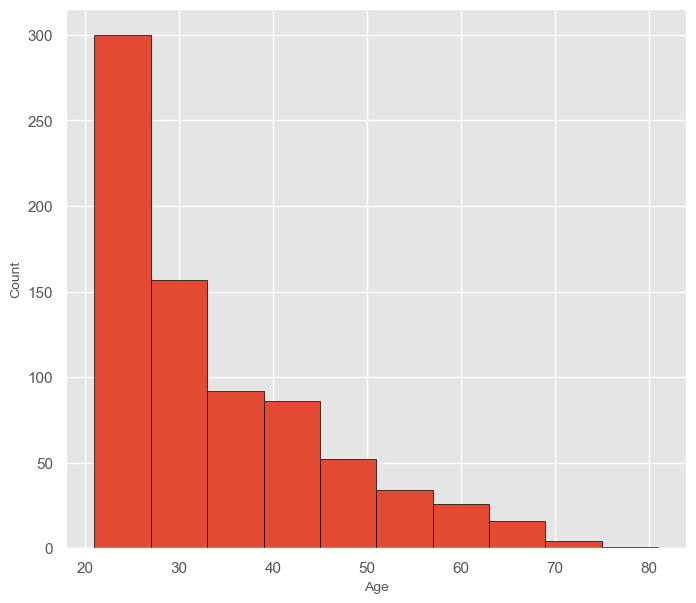

In [40]:
# Plot a histogram of the 'Age' feature
plt.figure(figsize=(8,7))
plt.xlabel('Age', fontsize=10)
plt.ylabel('Count', fontsize=10)
df['Age'].hist(edgecolor="black")
plt.show()

In [41]:
# Print the max and min age
print("MAX AGE: "+str(df['Age'].max()))
print("MIN AGE: "+str(df['Age'].min()))

MAX AGE: 81
MIN AGE: 21


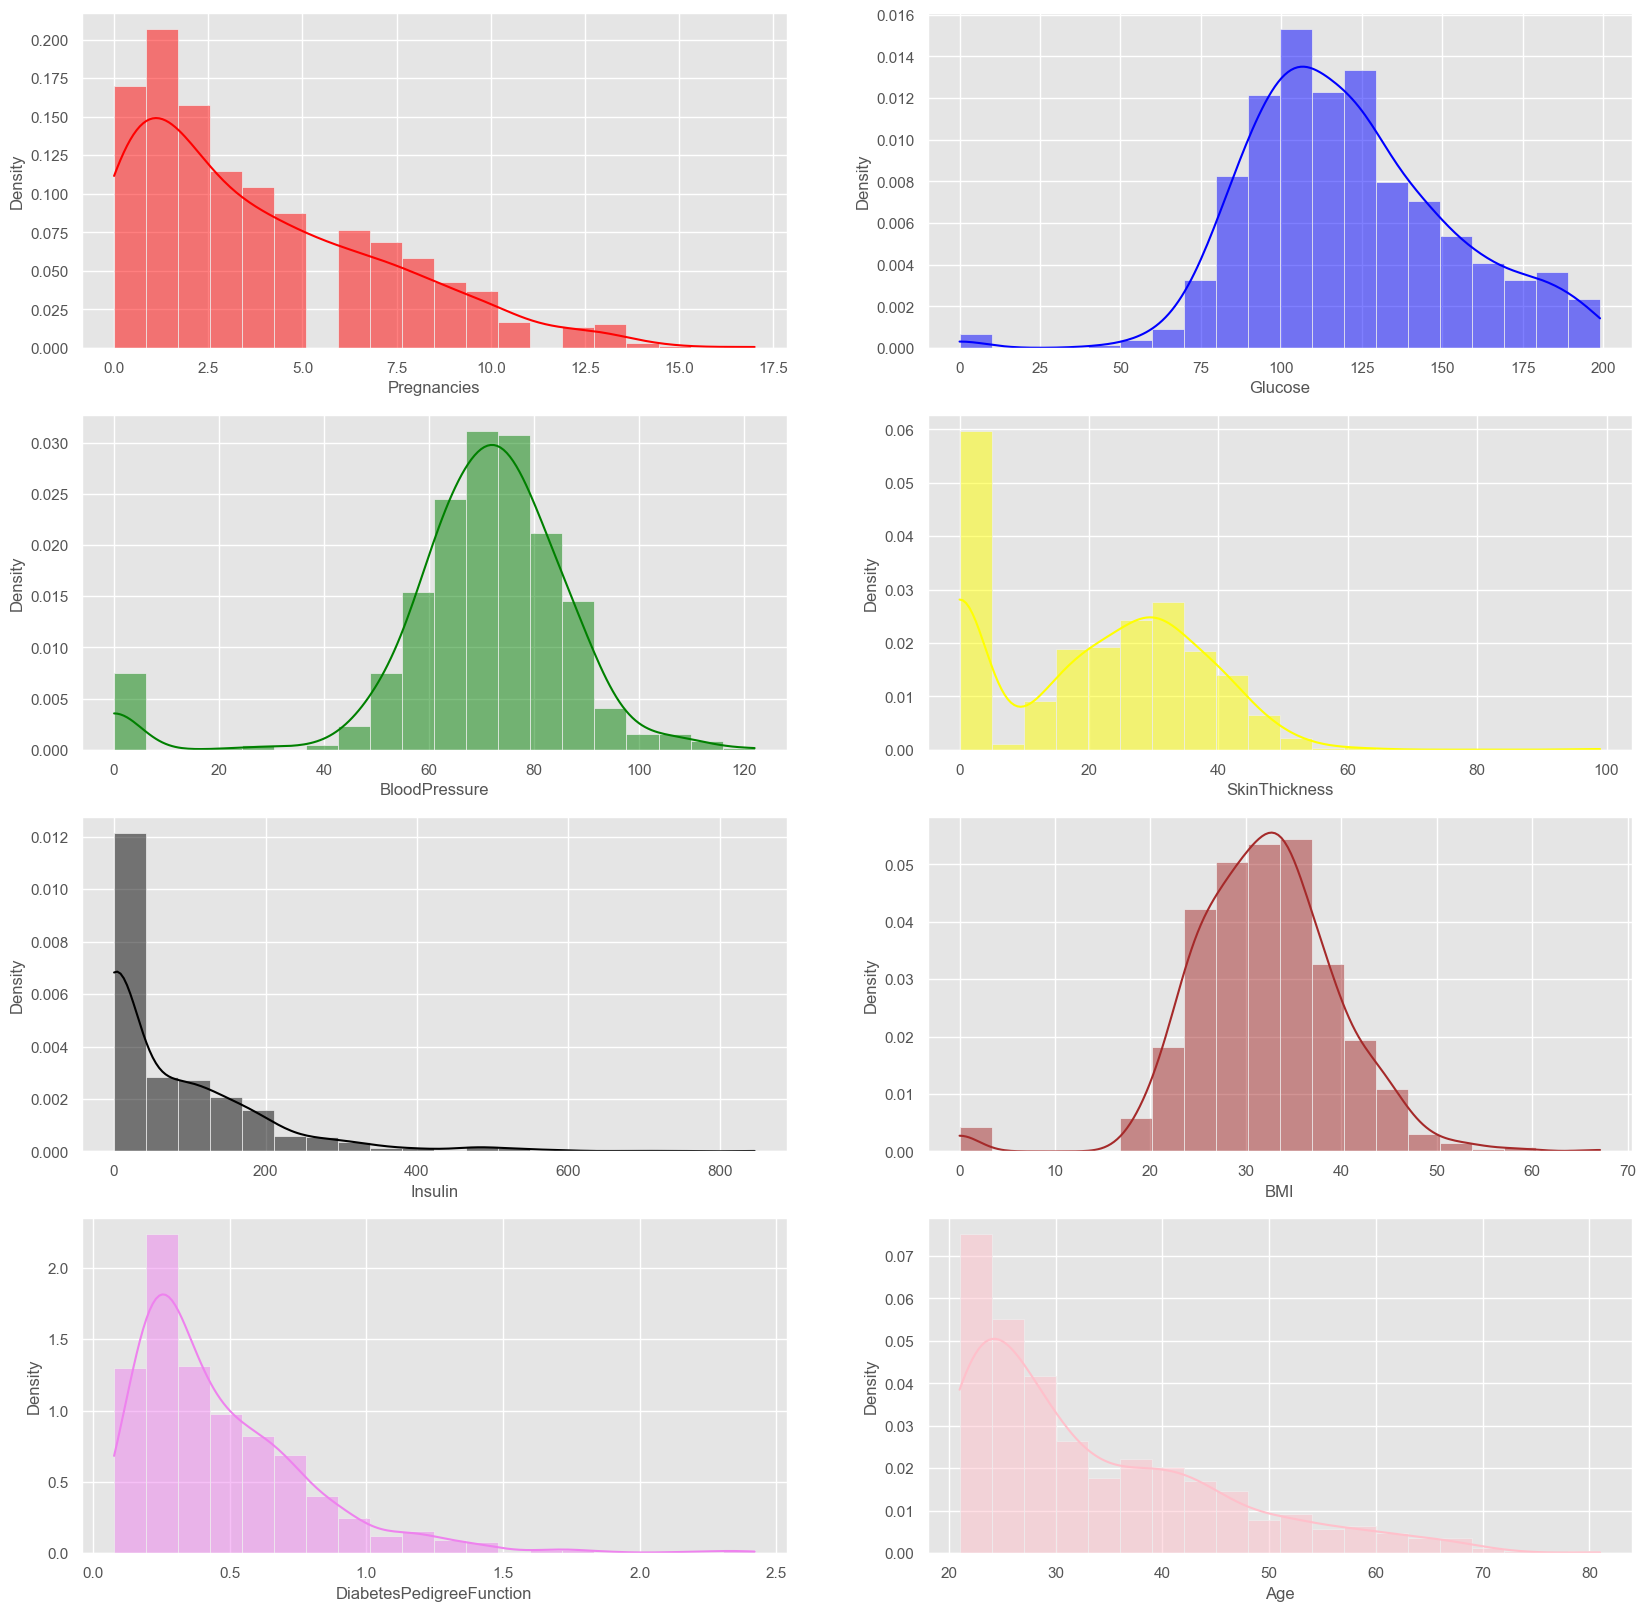

In [42]:
# Plot density graphs for all numerical features

fig, ax = plt.subplots(4, 2, figsize=(20, 20))
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
colors = ["red", "blue", "green", "yellow", "black", "brown", "violet", "pink"]

for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=20, ax=ax[i//2, i%2], color=colors[i], kde=True, stat="density")
plt.show()

In [43]:
def group_stats(df, feature_list, outcome_col='Outcome'):
    """Computes mean and max for given features grouped by outcome."""
    return df.groupby(outcome_col)[feature_list].agg(['mean', 'max'])

grouped_features = group_stats(df, ['Pregnancies', 'Glucose'])

In [44]:
# Homework
# 'BloodPressure', 'SkinThickness', 'Insulin',
#        'BMI', 'DiabetesPedigreeFunction', 'Age'
#     groupby-> mean/max

# 0>healthy
# 1>diabetes

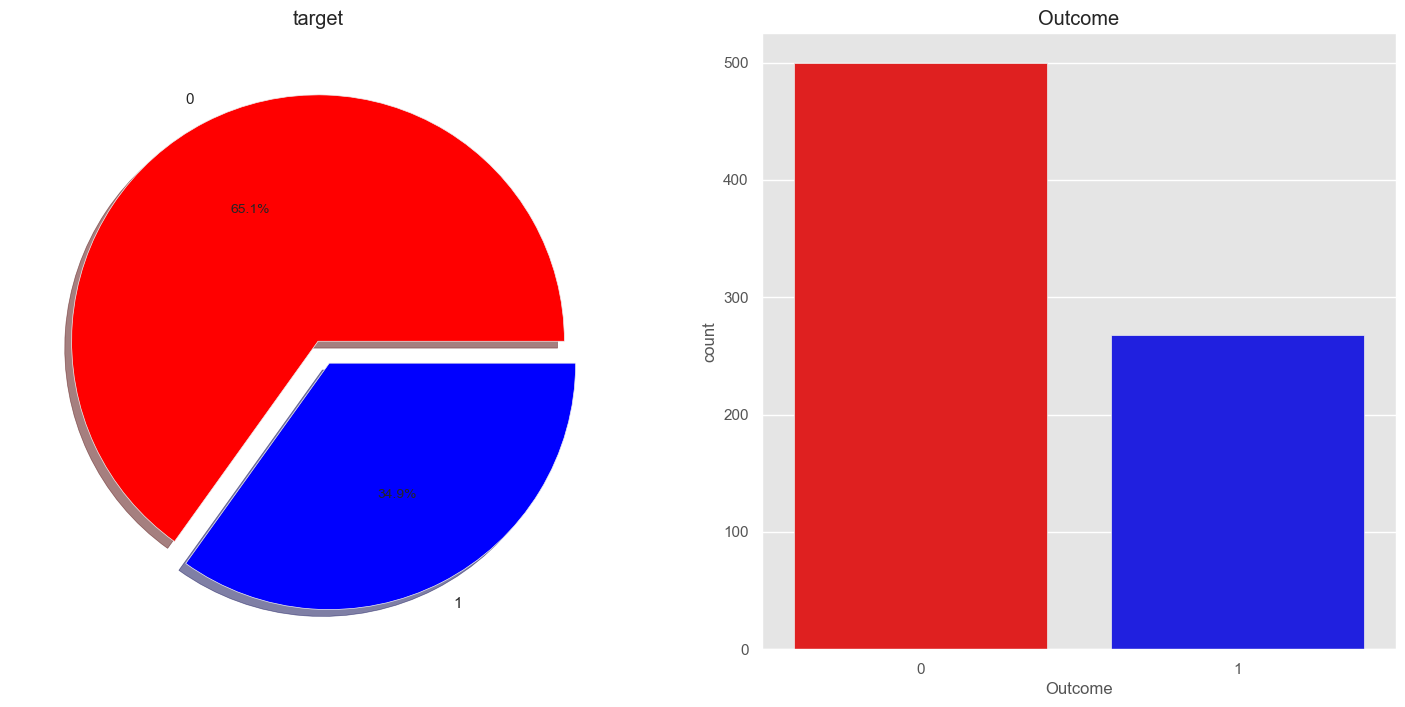

In [45]:
"""
This code snippet creates a subplot with two visualizations to analyze the 'Outcome' column in a DataFrame `df`.

The first subplot is a pie chart that shows the distribution of the 'Outcome' values, with the following properties:
- Explodes the second slice slightly for emphasis.
- Displays the percentage of each slice.
- Uses a shadow effect.
- Colors the slices red and blue.

The second subplot is a count plot that shows the count of each 'Outcome' value, with the following properties:
- Uses a red and blue color palette.

Both subplots have titles, and the first subplot has an empty y-label.

Parameters:
- df (DataFrame): The DataFrame containing the 'Outcome' column to be visualized.

Returns:
- None: This function does not return any value. It displays the plots directly.
"""
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df['Outcome'].value_counts().plot.pie(
    explode=[0, 0.1],
    autopct="%1.1f%%",
    ax=ax[0],
    shadow=True,
    colors=['red', 'blue']
)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot(
    x='Outcome',
    data=df,
    ax=ax[1],
    palette=['red', 'blue']
)
ax[1].set_title('Outcome')
plt.show()

In [46]:
df.corr()
"""
Calculates the correlation matrix for the DataFrame `df`.

Returns:
  DataFrame: A DataFrame containing the correlation coefficients between the columns of `df`.
"""

'\nCalculates the correlation matrix for the DataFrame `df`.\n\nReturns:\n  DataFrame: A DataFrame containing the correlation coefficients between the columns of `df`.\n'

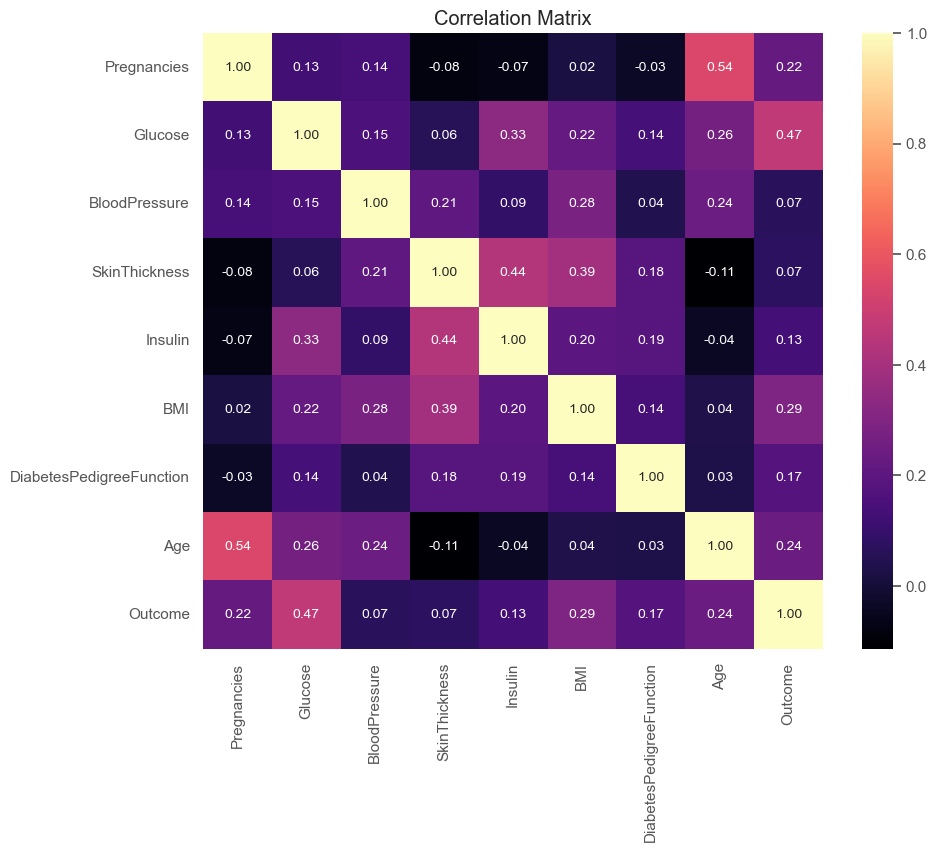

In [47]:
# Check correlation between features using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="magma")
plt.title("Correlation Matrix")
plt.show()

### Exploratory Data Analysis(EDA) Part Completed


In [48]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

### ---------------------------
### 2. Data Preprocessing
### ---------------------------

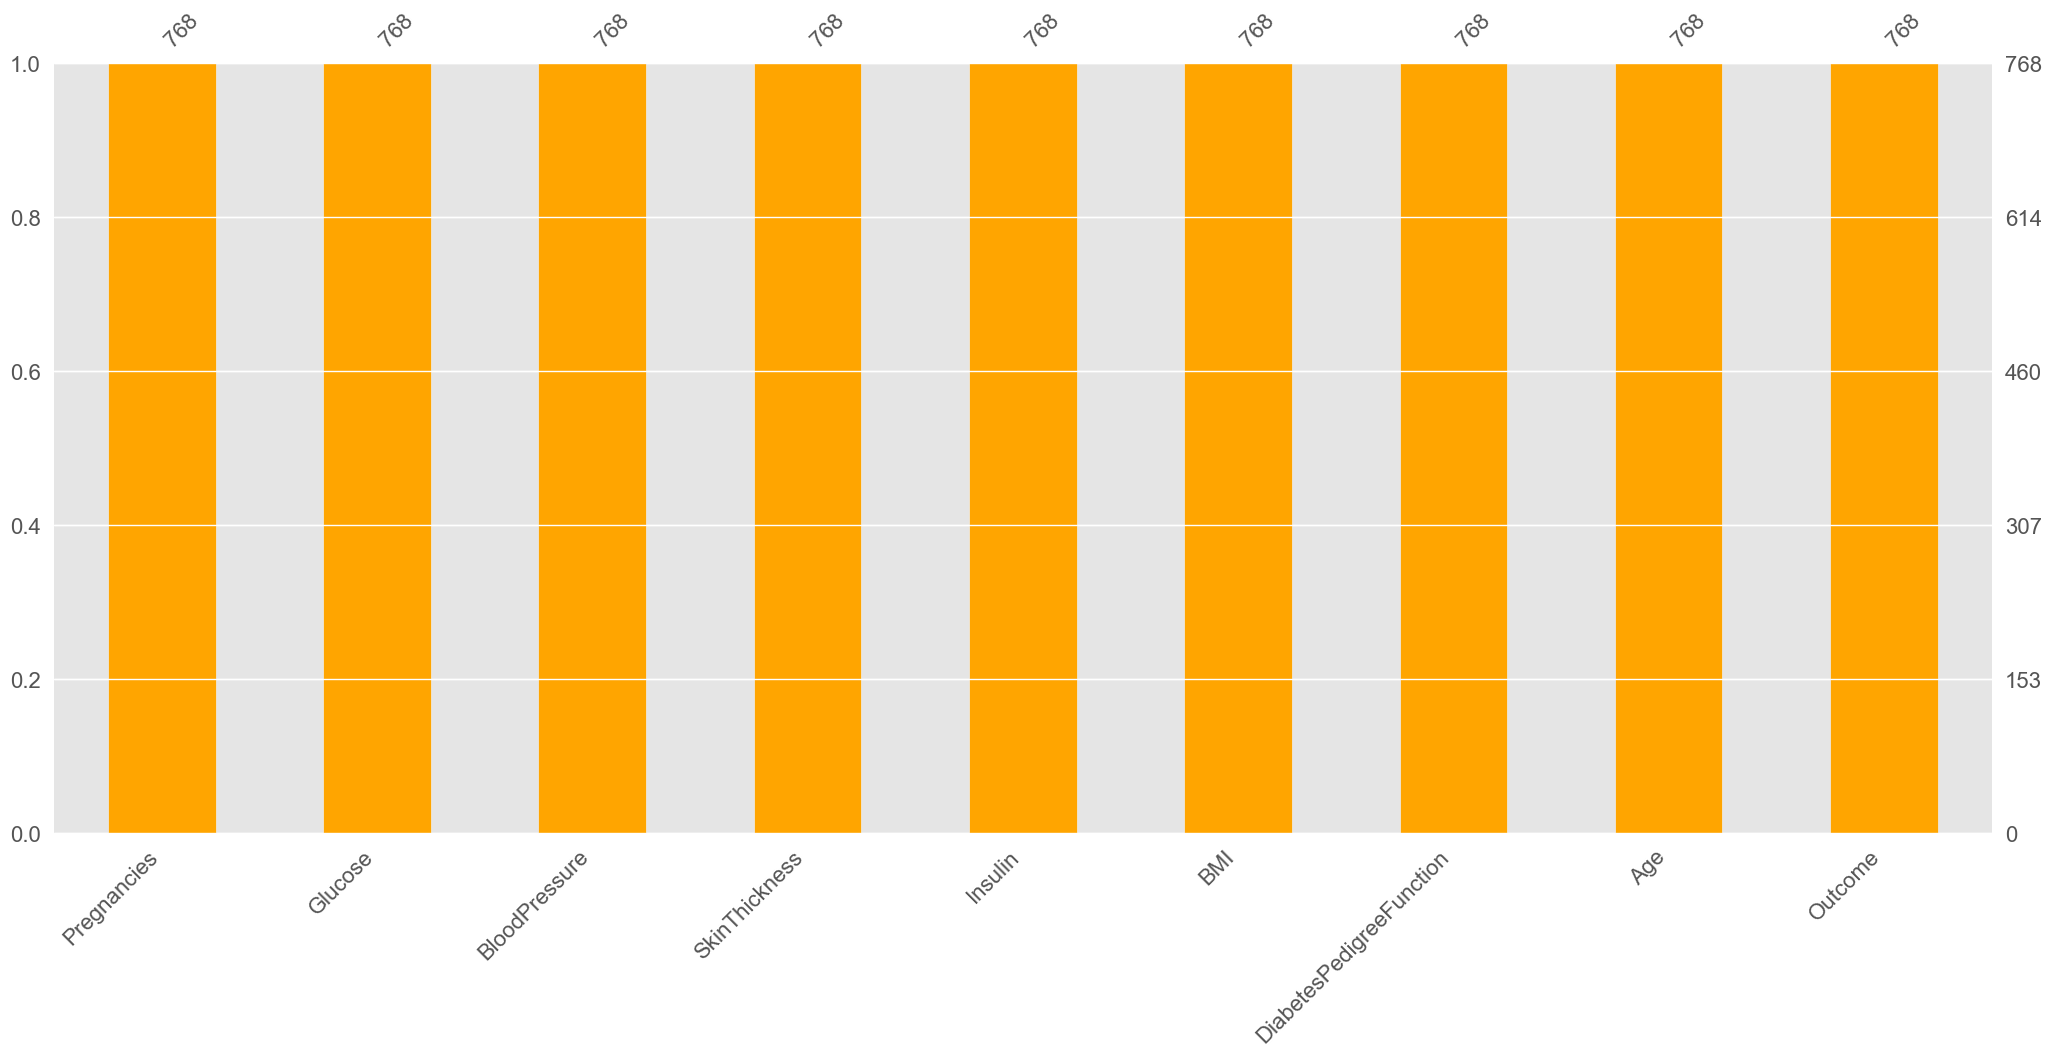

In [49]:
# Visualize missing values
import missingno as msno
msno.bar(df, color="orange")
plt.show()

In [50]:
def replace_zeros(data, columns):
    data[columns] = data[columns].replace(0, np.nan)
    return data


zero_columns = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]
df = replace_zeros(df, zero_columns)

In [51]:
# Impute missing values using median values grouped by Outcome
for col in df.columns.drop("Outcome"):
    medians = df.groupby("Outcome")[col].median()
    df.loc[(df["Outcome"] == 0) & (df[col].isnull()), col] = medians.loc[0]
    df.loc[(df["Outcome"] == 1) & (df[col].isnull()), col] = medians.loc[1]

In [52]:
# Check missing values
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [53]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


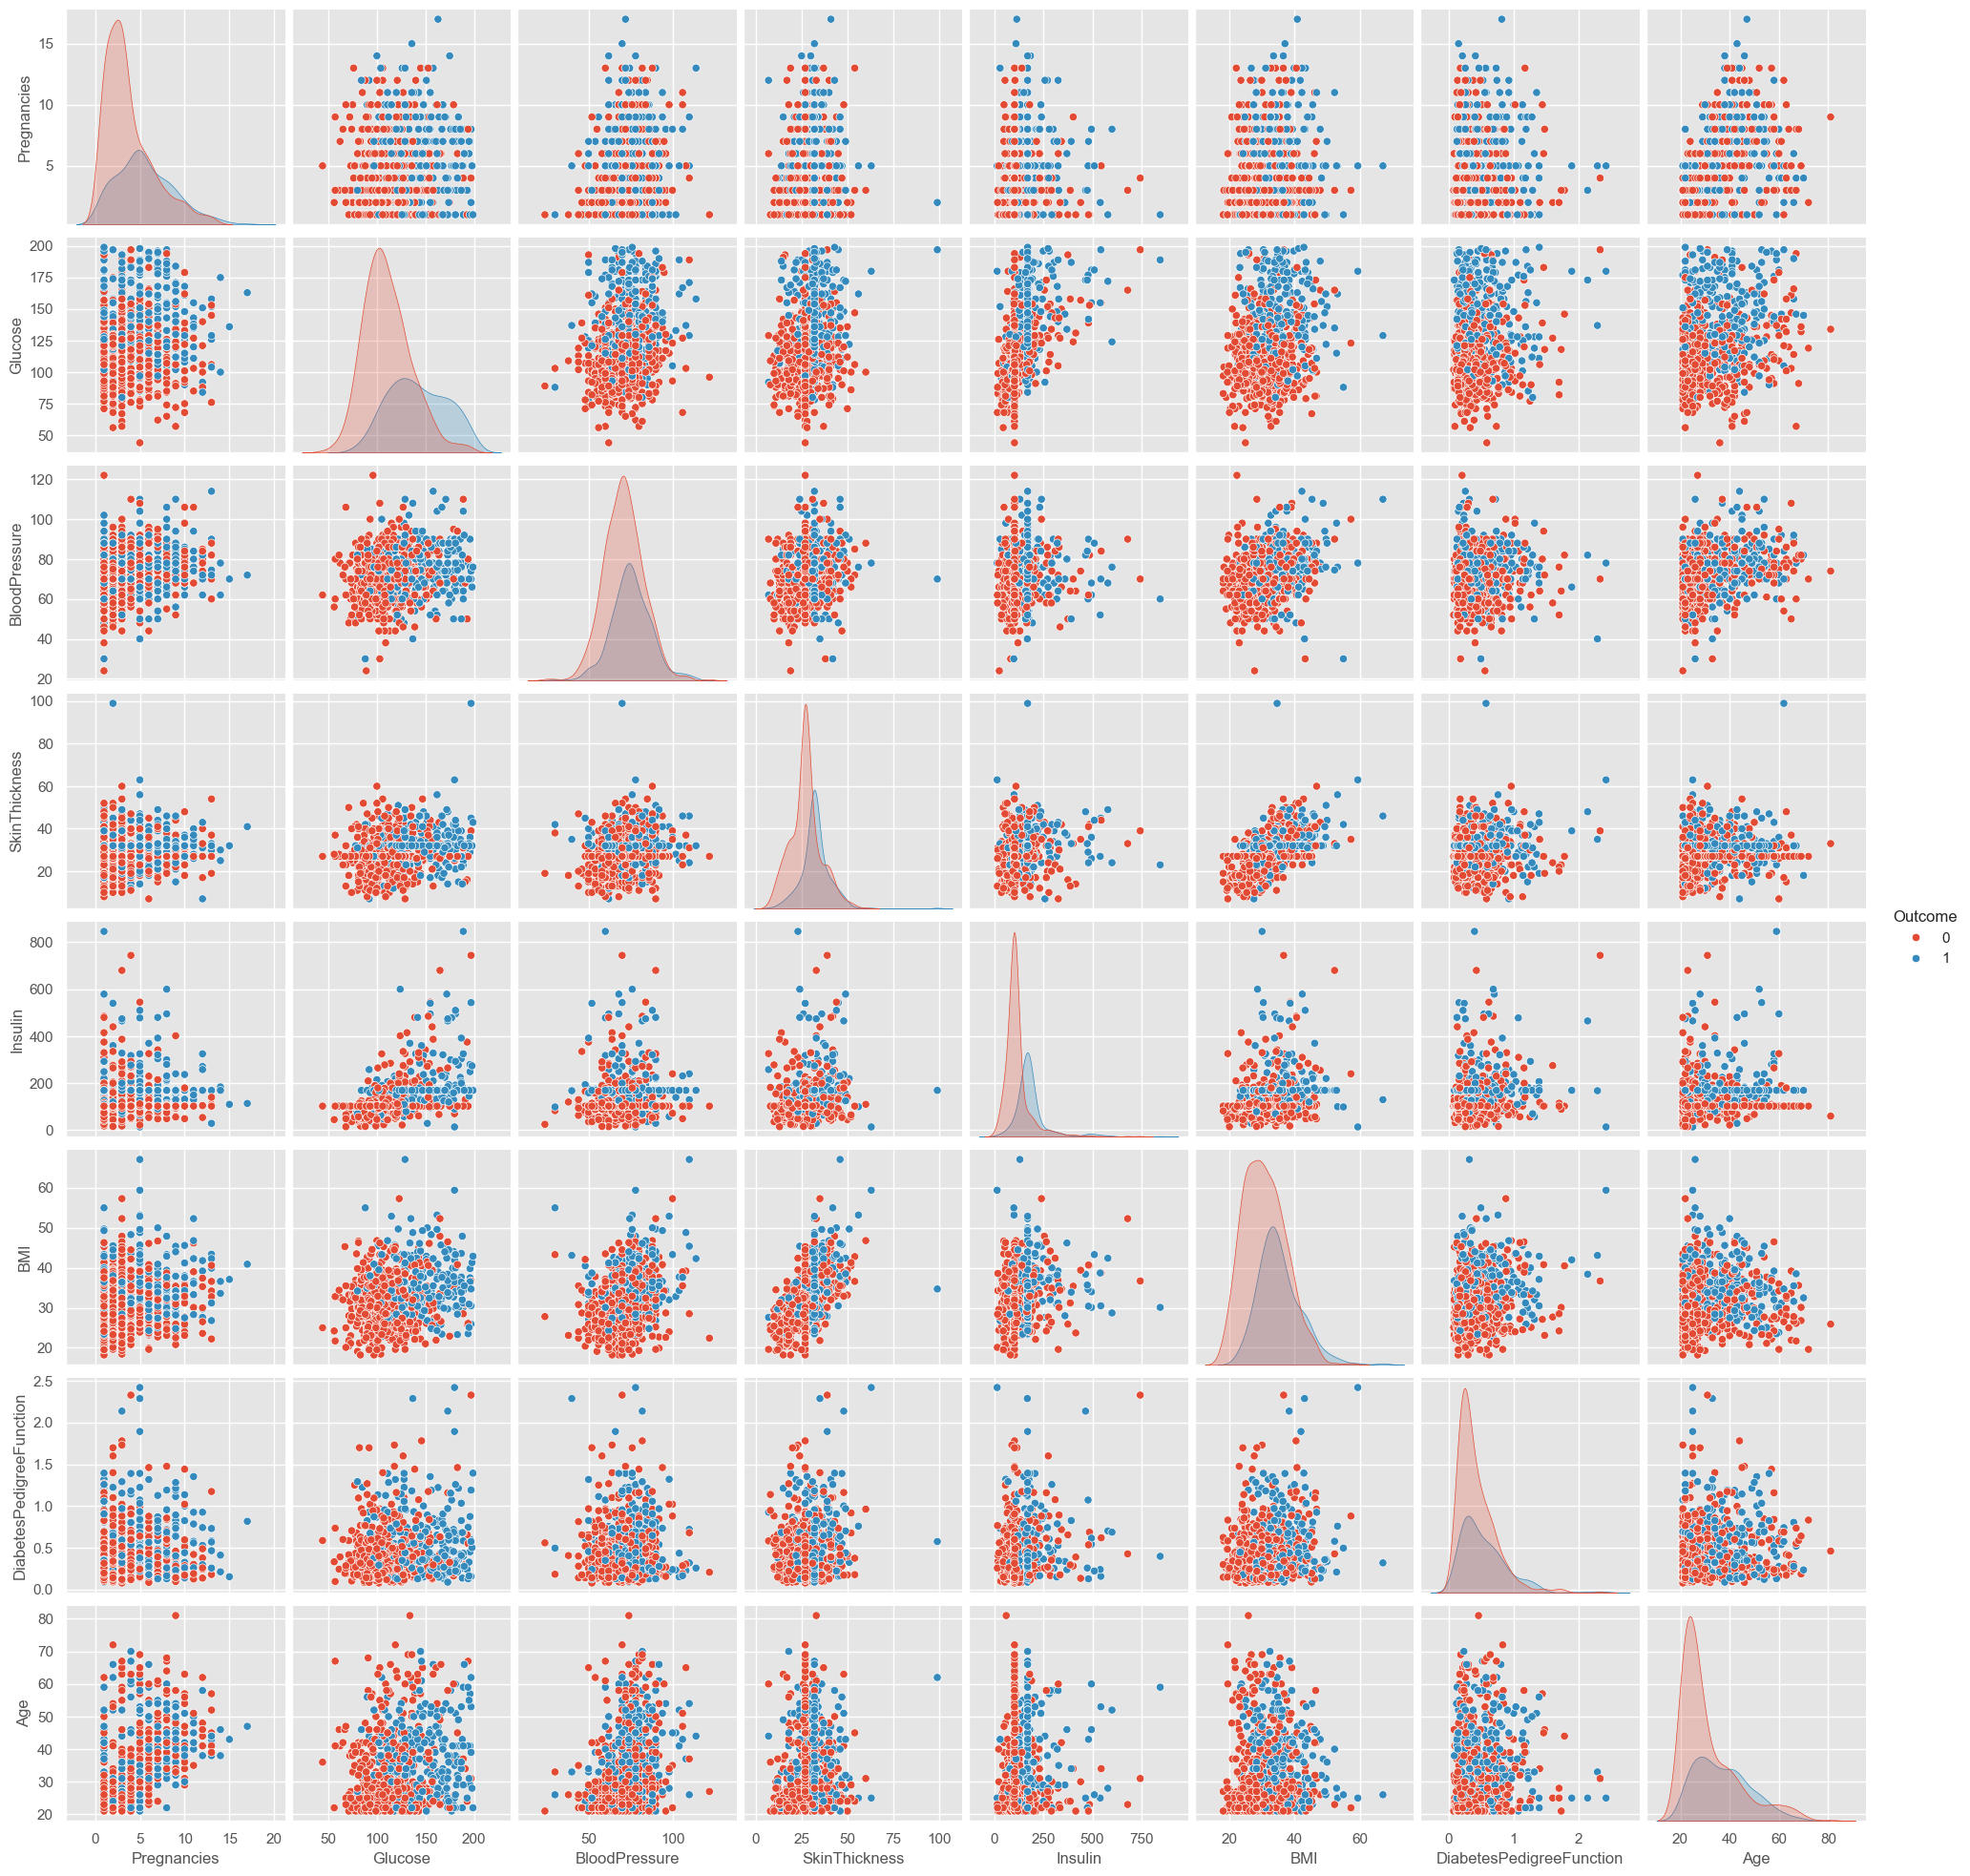

In [54]:
# Pairplot to explore relationships between features and the target variable
p = sns.pairplot(df, hue="Outcome")
plt.show()

In [55]:
# Cap outliers using IQR method for continuous variables
def cap_outliers(data, cols, threshold=1.5):
    for col in cols:
        Q1, Q3 = data[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - threshold * IQR, Q3 + threshold * IQR
        data[col] = np.clip(data[col], lower, upper)
    return data


cont_cols = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
]
df = cap_outliers(df, cont_cols)

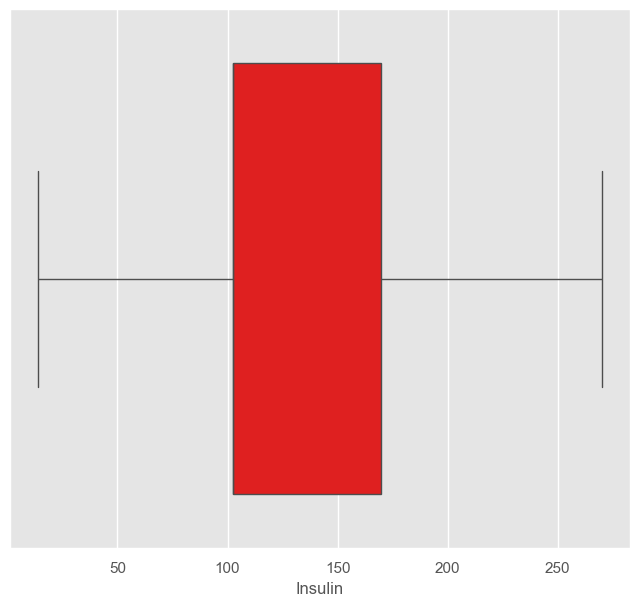

In [56]:
# Visualize outliers for 'Insulin'
plt.figure(figsize=(8,7))
sns.boxplot(x= df["Insulin"], color="red")
plt.show()

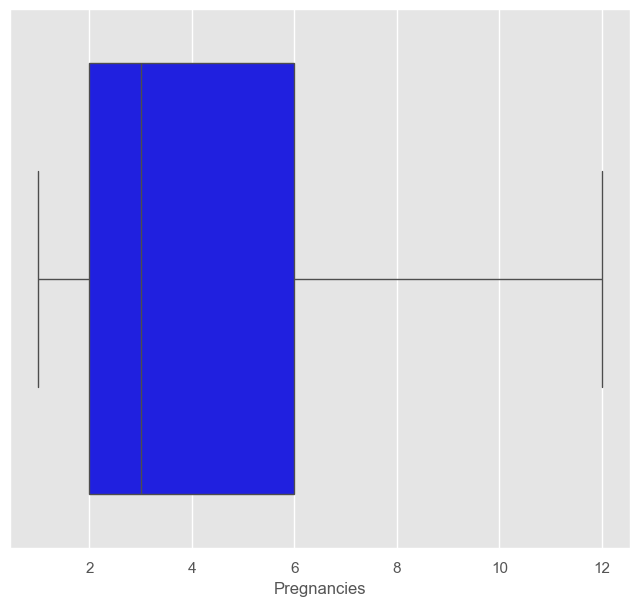

In [57]:
plt.figure(figsize=(8,7))
sns.boxplot(x= df["Pregnancies"], color="blue")
plt.show()

In [58]:
df.shape

(768, 9)

### ---------------------------
### 3. Feature Engineering
### ---------------------------

In [59]:
# Categorize BMI into groups (we then later one-hot encode these)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif bmi <= 24.9:
        return "Normal"
    elif bmi <= 29.9:
        return "Overweight"
    elif bmi <= 34.9:
        return "Obesity1"
    elif bmi <= 39.9:
        return "Obesity2"
    else:
        return "Obesity3"


df["BMI_Category"] = df["BMI"].apply(categorize_bmi)

In [60]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity1
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,Overweight
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight
4,5.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,Obesity3


In [61]:
# Categorize Insulin levels
def insulin_category(ins):
    return "Normal" if 16 <= ins <= 166 else "Abnormal"


df["Insulin_Category"] = df["Insulin"].apply(insulin_category)

In [62]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Insulin_Category
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity1,Abnormal
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,Overweight,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal,Abnormal
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal
4,5.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,Obesity3,Abnormal


In [63]:
# Categorize Glucose levels
def glucose_category(gluc):
    if gluc <= 70:
        return "Low"
    elif gluc <= 99:
        return "Normal"
    elif gluc <= 126:
        return "Overweight"
    else:
        return "Secret"


df["Glucose_Category"] = df["Glucose"].apply(glucose_category)

In [64]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,BMI_Category,Insulin_Category,Glucose_Category
0,6.0,148.0,72.0,35.0,169.5,33.6,0.627,50.0,1,Obesity1,Abnormal,Secret
1,1.0,85.0,66.0,29.0,102.5,26.6,0.351,31.0,0,Overweight,Normal,Normal
2,8.0,183.0,64.0,32.0,169.5,23.3,0.672,32.0,1,Normal,Abnormal,Secret
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0,Overweight,Normal,Normal
4,5.0,137.0,40.0,35.0,168.0,43.1,1.200,33.0,1,Obesity3,Abnormal,Secret


In [65]:
# One-hot encode the new categorical features
df = pd.get_dummies(
    df,
    columns=["BMI_Category", "Insulin_Category", "Glucose_Category"],
    drop_first=True,
)

#### ---------------------------
#### 4. Prepare Data for Modeling
#### ---------------------------

In [66]:
# Separate target and features
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [ ]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,BMI_Category_Obesity1,BMI_Category_Obesity2,BMI_Category_Obesity3,BMI_Category_Overweight,BMI_Category_Underweight,Insulin_Category_Normal,Glucose_Category_Normal,Glucose_Category_Overweight,Glucose_Category_Secret
44,7.0,159.0,64.0,27.0,102.5,27.4,0.294,40.0,False,False,False,True,False,True,False,False,True
672,10.0,68.0,104.0,23.0,49.0,35.5,0.285,47.0,False,True,False,False,False,True,False,False,False
700,2.0,122.0,76.0,27.0,200.0,35.9,0.483,26.0,False,True,False,False,False,False,False,True,False
630,7.0,114.0,64.0,32.0,169.5,27.4,0.732,34.0,False,False,False,True,False,False,False,True,False
81,2.0,74.0,70.0,27.0,102.5,30.1,0.102,22.0,True,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,3.0,88.0,58.0,14.5,54.0,24.8,0.267,22.0,False,False,False,False,False,True,True,False,False
637,2.0,94.0,76.0,18.0,66.0,31.6,0.649,23.0,True,False,False,False,False,True,True,False,False
593,2.0,82.0,52.0,22.0,115.0,28.5,1.200,25.0,False,False,False,True,False,True,True,False,False
425,4.0,184.0,78.0,39.0,270.0,37.0,0.264,31.0,False,True,False,False,False,False,False,False,True


### ---------------------------
### 5. Building Pipelines and Models
### ---------------------------


In [ ]:
# Here we use StandardScaler. If you want polynomial features, you can add that step.
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
    ]
)

Pipeline(steps=[('scaler', StandardScaler())])

In [139]:
# Example models and hyperparameter grids
param_grid_lr = {"clf__C": [0.01, 0.1, 1, 10, 100], "clf__penalty": ["l1", "l2"]}

pipe_lr = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", LogisticRegression(solver="liblinear", random_state=RANDOM_STATE)),
    ]
)

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)
print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Logistic Regression CV Accuracy:", grid_lr.best_score_)

Best Logistic Regression Params: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Logistic Regression CV Accuracy: 0.8566706650673064


In [140]:
# Similarly, set up a tuned SVM pipeline (example tuning)
param_grid_svc = {"clf__C": [0.1, 1, 10], "clf__gamma": [0.001, 0.01, 0.1]}

pipe_svc = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clf", SVC(probability=True, random_state=RANDOM_STATE)),
    ]
)

grid_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring="accuracy", n_jobs=-1)
grid_svc.fit(X_train, y_train)
print("Best SVC Params:", grid_svc.best_params_)
print("SVC CV Accuracy:", grid_svc.best_score_)

Best SVC Params: {'clf__C': 1, 'clf__gamma': 0.1}
SVC CV Accuracy: 0.8615487138477942


In [141]:
# Train additional models (Decision Tree, KNN, RandomForest, GradientBoosting, XGBoost)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(preprocessor.fit_transform(X_train), y_train)
knn = KNeighborsClassifier()
knn.fit(preprocessor.fit_transform(X_train), y_train)
rf = RandomForestClassifier(
    n_estimators=130,
    max_depth=15,
    min_samples_leaf=2,
    min_samples_split=3,
    random_state=RANDOM_STATE,
    class_weight="balanced",
)
rf.fit(preprocessor.fit_transform(X_train), y_train)
gbc = GradientBoostingClassifier(
    learning_rate=0.1, n_estimators=150, loss="exponential", random_state=RANDOM_STATE
)
gbc.fit(preprocessor.fit_transform(X_train), y_train)

GradientBoostingClassifier(loss='exponential', n_estimators=150,
                           random_state=42)

In [142]:
# For XGBoost (if installed)
try:
    from xgboost import XGBClassifier

    xgb = XGBClassifier(
        objective="binary:logistic",
        learning_rate=0.01,
        max_depth=10,
        n_estimators=180,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric="logloss",
    )
    xgb.fit(preprocessor.fit_transform(X_train), y_train)
except ImportError:
    xgb = None

### ---------------------------
### 6. Ensemble and Stacking
### ---------------------------

In [143]:
# Create a soft voting classifier ensemble with tuned models
estimators = [
    ("lr", grid_lr.best_estimator_),
    ("svc", grid_svc.best_estimator_),
    ("rf", rf),
]

voting_clf = VotingClassifier(estimators=estimators, voting="soft", n_jobs=-1)
voting_clf.fit(X_train, y_train)
voting_pred = voting_clf.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, voting_pred))

Voting Classifier Accuracy: 0.8831168831168831


In [144]:
# Alternatively, use stacking
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(solver="liblinear", random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
)
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)
print("Stacking Classifier Accuracy:", accuracy_score(y_test, stacking_pred))

Stacking Classifier Accuracy: 0.8766233766233766


### ---------------------------
### 7. Calibration (for better probability estimates)
### ---------------------------


In [145]:
calibrated_svc = CalibratedClassifierCV(
    estimator=grid_svc.best_estimator_, method="isotonic", cv=5
)
calibrated_svc.fit(X_train, y_train)
print(
    "Calibrated SVC Accuracy:", accuracy_score(y_test, calibrated_svc.predict(X_test))
)

Calibrated SVC Accuracy: 0.8896103896103896


### ---------------------------
### 8. Evaluate Models & Save Metrics
### ---------------------------

In [146]:
# Collect metrics from each model
models_eval = {
    "Logistic Regression": grid_lr.best_estimator_,
    "SVC": grid_svc.best_estimator_,
    "Decision Tree": dt,
    "KNN": knn,
    "Random Forest": rf,
    "Gradient Boosting": gbc,
}

if xgb is not None:
    models_eval["XGBoost"] = xgb

In [147]:
eval_results = []
for name, model in models_eval.items():
    # Get predictions (if using a pipeline, no need to call preprocessor separately)
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(preprocessor.transform(X_test))
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    eval_results.append(
        {
            "Model": name,
            "Accuracy": round(acc * 100, 2),
            "Precision": round(prec * 100, 2),
            "Recall": round(rec * 100, 2),
            "F1 Score": round(f1 * 100, 2),
        }
    )
    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       100
           1       0.77      0.85      0.81        54

    accuracy                           0.86       154
   macro avg       0.84      0.86      0.85       154
weighted avg       0.86      0.86      0.86       154

--- SVC ---
              precision    recall  f1-score   support

           0       0.88      0.91      0.89       100
           1       0.82      0.76      0.79        54

    accuracy                           0.86       154
   macro avg       0.85      0.83      0.84       154
weighted avg       0.86      0.86      0.86       154

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.35      1.00      0.52        54

    accuracy                           0.35       154
   macro avg       0.18      0.50      0.26       154
weighted avg

In [148]:
# Save metrics to JSON
models_df = pd.DataFrame(eval_results)

In [149]:
# Optionally sort by Accuracy or a composite Score (here using Accuracy)
models_df = models_df.sort_values(by="Accuracy", ascending=False)
metrics_dict = models_df.set_index("Model").T.to_dict()

In [150]:
# Create directory if not exists
os.makedirs("models", exist_ok=True)
metrics_file_path = os.path.join("models", "metrics.json")
with open(metrics_file_path, "w") as f:
    json.dump(metrics_dict, f, indent=4)
print(f"Saved model metrics to {metrics_file_path}")

Saved model metrics to models\metrics.json


### ---------------------------
### 9. Save Models (Pickle)
### ---------------------------

In [151]:
# Save each model in the models_eval dictionary
for name, model in models_eval.items():
    model_filename = os.path.join("../models", f"{name.replace(' ', '_').lower()}.pkl")
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Saved {name} to {model_filename}")

Saved Logistic Regression to models\logistic_regression.pkl
Saved SVC to models\svc.pkl
Saved Decision Tree to models\decision_tree.pkl
Saved KNN to models\knn.pkl
Saved Random Forest to models\random_forest.pkl
Saved Gradient Boosting to models\gradient_boosting.pkl
Saved XGBoost to models\xgboost.pkl


In [152]:
# Optionally save the ensemble models
ensemble_models = {
    "VotingClassifier": voting_clf,
    "StackingClassifier": stacking_clf,
    "Calibrated_SVC": calibrated_svc,
    "Preprocessor": preprocessor,
}
for name, model in ensemble_models.items():
    model_filename = os.path.join("../models", f"{name.replace(' ', '_').lower()}.pkl")
    with open(model_filename, "wb") as file:
        pickle.dump(model, file)
    print(f"Saved {name} to {model_filename}")


Saved VotingClassifier to models\votingclassifier.pkl
Saved StackingClassifier to models\stackingclassifier.pkl
Saved Calibrated_SVC to models\calibrated_svc.pkl
Saved Preprocessor to models\preprocessor.pkl


### ---------------------------
### 10. Plot ROC Curves for Comparison
### ---------------------------

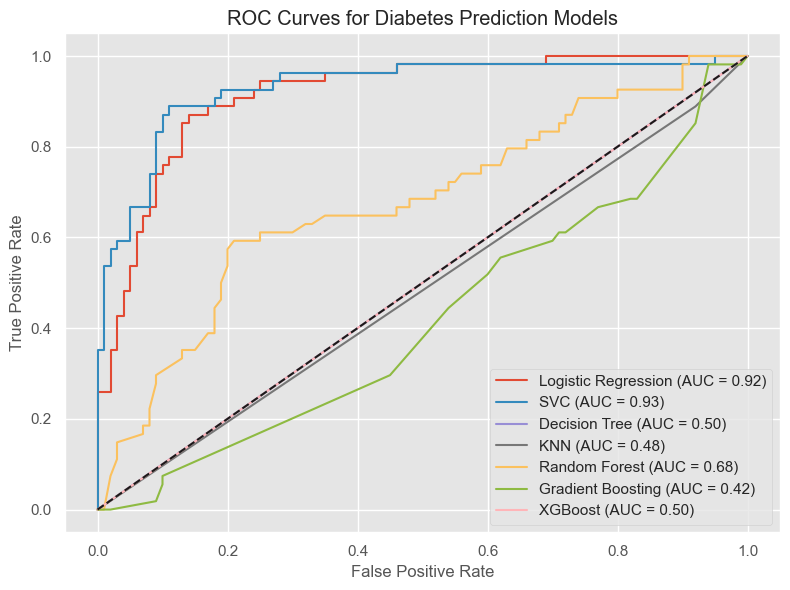

In [153]:
plt.figure(figsize=(8, 6))
for name, model in models_eval.items():
    # Use pipelines directly or transform X_test with preprocessor if needed.
    if hasattr(model, "predict_proba"):
        probas_ = model.predict_proba(X_test)[:, 1]
    else:
        probas_ = model.predict(preprocessor.transform(X_test))
    fpr, tpr, _ = roc_curve(y_test, probas_)
    auc_val = roc_auc_score(y_test, probas_)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Diabetes Prediction Models")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_diabetes.jpeg", format="jpeg", dpi=300)
plt.show()